In [ ]:
import numpy as np 
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import os
#import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import Sequential
from tensorflow.keras.applications import InceptionResNetV2, DenseNet169, ResNet152V2
from tensorflow.keras.layers import Dense


In [ ]:
train_image_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/train_images'
test_image_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/test_images' 
train_df_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '/content/drive/MyDrive/plant-pathology-2021-fgvc8/sample_submission.csv'

In [ ]:
df_train = pd.read_csv(train_df_path)
df_test=pd.read_csv(test_df_path)

In [ ]:
print(df_test)

                  image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy


In [ ]:
df_train = df_train[(df_train['labels'] == 'healthy') | (df_train['labels'] == 'scab')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df_train)

                      image   labels
0      800113bb65efe69e.jpg  healthy
2      80070f7fb5e2ccaa.jpg     scab
3      80077517781fb94f.jpg     scab
5      800edef467d27c15.jpg  healthy
7      801d6dcd96e48ebc.jpg  healthy
...                     ...      ...
18625  fffaa4a0fe416808.jpg     scab
18626  fffb65761200b054.jpg  healthy
18627  fffb900a92289a33.jpg  healthy
18628  fffc488fa4c0e80c.jpg     scab
18631  fffe472a0001bd25.jpg  healthy

[9450 rows x 2 columns]


In [ ]:
train_df, dummy_df = train_test_split(df_train,  train_size= 0.7, shuffle= True,random_state=123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.3, shuffle= True,random_state=123)

In [ ]:
CLASSES = df_train['labels'].unique().tolist()


In [ ]:
print(CLASSES)

['healthy', 'scab']


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_dataframe(
   train_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical',shuffle= True, batch_size= 64)
val_generator = train_datagen.flow_from_dataframe(
   valid_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical', shuffle= True, batch_size= 64)
test_generator = train_datagen.flow_from_dataframe(
   test_df, directory= train_image_path, x_col= 'image', y_col= 'labels', target_size= (224,224),
                                            class_mode= 'categorical',shuffle= False, batch_size= 64)

Found 6611 validated image filenames belonging to 2 classes.
Found 935 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 1899 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.applications import Xception
xcept = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
xcept.trainable = False
print(xcept.summary())


83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
model = tf.keras.models.Sequential([
    xcept,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2)                 200706    
                                                                 
Total params: 21,062,186
Trainable params: 200,706
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [ ]:
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=8,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[earlystop]

In [ ]:
c = model.fit(
    train_generator,
    steps_per_epoch = 6611//64,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = (935//64),
    max_queue_size=100,
    workers = 4 ,
    verbose = 1,
callbacks=callbacks)

Epoch 1/10
103/103 [==============================] - 928s 9s/step - loss: 1.3026 - accuracy: 0.7668 - val_loss: 0.7580 - val_accuracy: 0.8147
Epoch 2/10
103/103 [==============================] - 580s 5s/step - loss: 0.4364 - accuracy: 0.8619 - val_loss: 0.4508 - val_accuracy: 0.8549
Epoch 3/10
103/103 [==============================] - 588s 6s/step - loss: 0.3353 - accuracy: 0.8903 - val_loss: 0.4825 - val_accuracy: 0.8583
Epoch 4/10
103/103 [==============================] - 565s 5s/step - loss: 0.1602 - accuracy: 0.9377 - val_loss: 0.4444 - val_accuracy: 0.8661
Epoch 5/10
103/103 [==============================] - 554s 5s/step - loss: 0.1600 - accuracy: 0.9340 - val_loss: 0.5362 - val_accuracy: 0.8560
Epoch 6/10
103/103 [==============================] - 579s 5s/step - loss: 0.0868 - accuracy: 0.9664 - val_loss: 0.4320 - val_accuracy: 0.8728
Epoch 7/10
103/103 [==============================] - 576s 5s/step - loss: 0.0968 - accuracy: 0.9636 - val_loss: 0.5409 - val_accuracy: 0.8627

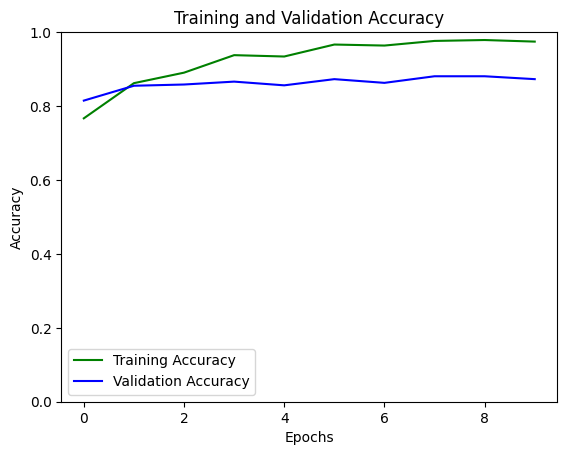

In [ ]:
acc_train=c.history['accuracy']
acc_val=c.history['val_accuracy']
epochs=range(len(acc_train))
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

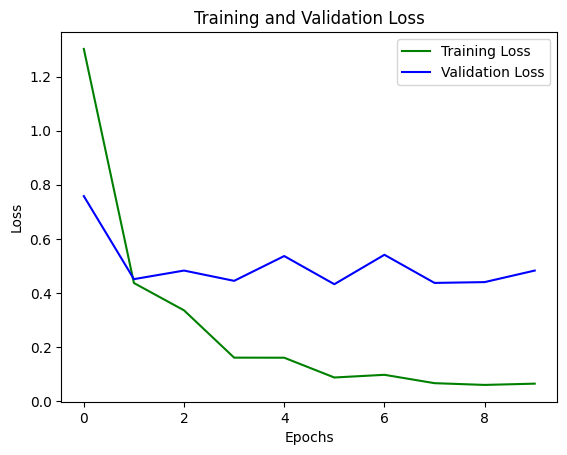

In [ ]:
loss_train=c.history['loss']
loss_val=c.history['val_loss']
epochs=range(len(loss_train))
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
train_accuracy = model.evaluate(train_generator,batch_size=128)[1] * 100
print('Train accuracy is : ',train_accuracy, '%' )

104/104 [==============================] - 854s 8s/step - loss: 0.0370 - accuracy: 0.9873
Train accuracy is :  98.72938990592957 %


In [ ]:
val_accuracy = model.evaluate(val_generator,batch_size=64)[1] * 100
print('val accuracy is : ',val_accuracy, '%' )

15/15 [==============================] - 131s 9s/step - loss: 0.5008 - accuracy: 0.8717
val accuracy is :  87.16577291488647 %


In [ ]:
test_accuracy = model.evaluate(test_generator,batch_size=64)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

30/30 [==============================] - 713s 24s/step - loss: 0.5697 - accuracy: 0.8541
Test accuracy is :  85.41337251663208 %


In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps = test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

30/30 [==============================] - 238s 8s/step


In [ ]:
import sklearn
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

     healthy       0.85      0.85      0.85       918
        scab       0.86      0.86      0.86       981

    accuracy                           0.85      1899
   macro avg       0.85      0.85      0.85      1899
weighted avg       0.85      0.85      0.85      1899



<Figure size 200x200 with 0 Axes>

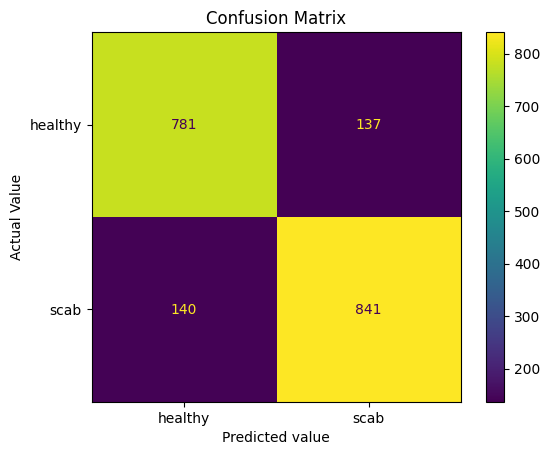

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
x=confusion_matrix(true_classes, predicted_classes)

x_display=metrics.ConfusionMatrixDisplay(confusion_matrix=x,display_labels=class_labels)
plt.figure(figsize=(2,2))
x_display.plot()

plt.title("Confusion Matrix")
plt.xlabel("Predicted value")
plt.ylabel("Actual Value")
plt.show()

In [ ]:
! pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


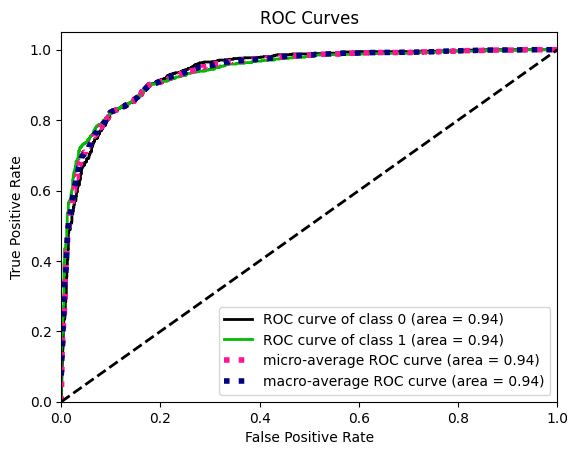

<Figure size 200x200 with 0 Axes>

In [ ]:
import scikitplot as skplt

y_true = true_classes
y_probas = predictions
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.figure(figsize=(2,2))
plt.show()